# Devils DFTD 2-Stage Infection Parameter Approximation + Immunity

In [1]:
import json
import numpy as np
import pandas as pd

import sys
sys.path.append('../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                    EventTrigger, EventAssignment, export_StochSS, \
                    RateRule
from gillespy2 import ODECSolver, ODESolver, SSACSolver, \
                        TauHybridCSolver, TauHybridSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, \
                    interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

## Read in observed data

In [2]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)

obs = np.vstack([devil_pop]).reshape(1, 1, -1)

# Devils DFTD 2-Stage Infection with Vaccination and Culling

In [3]:
#    "end_sim": 1000,
end_sim = 1000
variables = {
    "vaccinated_infection_rate": 0.25, # % of "break-through" cases
    "vaccination_proportion": 0.6,  # % of devil population that get vaccinated
    "vaccine_frequency": 3, #times per year we drop bait
    "vaccine_start": 0, # number of months after current date (0==Jan 2022)
    "program_length": 3, # number of years
    "cull_rate_infected": 0.00,
    "cull_rate_diseased": 0.2,
    "immunity_growth_rate": 0,
    "immunity_max_level": 0.5,
    "immunity_start": 200
}
variables_orig = variables.copy()

In [4]:
dates = []
year = 1985
while len(dates) < end_sim + 1:
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

In [37]:
class DevilsDFTD2StageInfectionWithVaccinationCullingImmunity(Model):
    def __init__(self, values=variables):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection with Vaccination")
        self.volume = 1

        # Parameters (Pre-Vaccination)
        birth_rate = Parameter(name="birth_rate", expression="0.055")
        death_rate_diseased = Parameter(name="death_rate_diseased", expression="0.048")
        death_rate_infected = Parameter(name="death_rate_infected", expression="0.03")
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression="0.006")
        death_rate_over_population = Parameter(name="death_rate_over_population", expression="2.3e-07")
        death_rate_susceptible = Parameter(name="death_rate_susceptible", expression="0.02335")
        incubation = Parameter(name="incubation", expression="22.6")
        infection_rate_diseased = Parameter(name="infection_rate_diseased", expression="3e-05")
        infection_rate_infected = Parameter(name="infection_rate_infected", expression="2e-05")
        maturity_rate = Parameter(name="maturity_rate", expression="0.04267")
        progression = Parameter(name="progression", expression="12")
        DFTD_introduction = Parameter(name="DFTD_introduction", expression="40")
        self.add_parameter([
            birth_rate, death_rate_diseased, death_rate_infected, death_rate_juvenile, death_rate_over_population,
            death_rate_susceptible, incubation, infection_rate_diseased, infection_rate_infected,
            maturity_rate, progression, DFTD_introduction
        ])
        
        # Parameters (Vaccination)
        vaccinated_infection_rate = Parameter(
            name="vaccinated_infection_rate", expression=values['vaccinated_infection_rate']
        )
        vaccination_proportion = Parameter(name="vaccination_proportion", expression=values['vaccination_proportion'])
        vaccine_frequency = Parameter(name="vaccine_frequency", expression=values['vaccine_frequency'])
        vaccine_start = Parameter(name="vaccine_start", expression=values['vaccine_start'])
        program_length = Parameter(name="program_length", expression=values['program_length'])
        self.add_parameter([
            vaccinated_infection_rate, vaccination_proportion, vaccine_frequency, vaccine_start, program_length
        ])
        
        # Parameter (Culling)
        cull_rate_diseased = Parameter(name="cull_rate_diseased", expression=0)
        cull_rate_infected = Parameter(name="cull_rate_infected", expression=0)
        self.add_parameter([
            cull_rate_diseased, cull_rate_infected, 
        ])
        
        # Parameters (Immunity)
        immunity_level = Species(name="immunity_level", initial_value=0, mode="continuous")
        self.add_species([immunity_level])
        immunity_growth_rate = Parameter(name="immunity_growth_rate", expression=values['immunity_growth_rate'])
        immunity_max_level = Parameter(name="immunity_max_level", expression=values['immunity_max_level'])
        immunity_start = Parameter(name="immunity_start", expression=values['immunity_start'])
        self.add_parameter([immunity_growth_rate, immunity_max_level, immunity_start])
        
        # Variables (Pre-Vaccination)
        init_Devils_pop = round(devil_pop[0])
        init_J_pop = round(devil_pop[0] * 0.467)
        init_S_pop = round(devil_pop[0] - init_J_pop)
        
        Devils = Species(name="Devils", initial_value=init_Devils_pop, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Juvenile = Species(name="Juvenile", initial_value=init_S_pop, mode="discrete")
        Susceptible = Species(name="Susceptible", initial_value=init_J_pop, mode="discrete")
        self.add_species([Devils, Diseased, Exposed, Infected, Juvenile, Susceptible])
        
        # Variables (Vaccination)
        Vaccinated = Species(name="Vaccinated", initial_value=0, mode="discrete")
        self.add_species(Vaccinated)
        
        # Reactions (Pre-Vaccination)
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected + Vaccinated)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased * (1.0-immunity_level)"
        )
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * Susceptible * Infected * (1.0-immunity_level)"
        )
        self.add_reaction([
            Birth, Mature, Death_Diseased, Death_Diseased2, Death_Exposed, Death_Exposed2, Death_Infected,
            Death_Infected2, Death_Juvenile, Death_Juvenile2, Death_Susceptible, Death_Susceptible2,
            DFTD_Stage1, DFTD_Stage2, TransmissionD, TransmissionI
        ])
        
        # Reactions (Vaccination)
        Vaccine_Failure_I = Reaction(name="Vaccine_Failure_I",
            reactants={'Vaccinated': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * vaccinated_infection_rate * Vaccinated * Infected / \
                                            (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Vaccine_Failure_D = Reaction(name="Vaccine_Failure_D",
            reactants={'Vaccinated': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * vaccinated_infection_rate * Vaccinated * Diseased / \
                                            (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Death_Vaccinated = Reaction(name="Death_Vaccinated",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_susceptible * Vaccinated"
        )
        Death_Vaccinated2 = Reaction(name="Death_Vaccinated2",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_over_population * Vaccinated * (Devils - 1)"
        )
        self.add_reaction([Vaccine_Failure_I, Vaccine_Failure_D, Death_Vaccinated, Death_Vaccinated2])


        
        # Reactions (Culling)
        Death_Cull_Infected = Reaction(name="Death_Cull_Infected",
            reactants={'Devils': 1, 'Infected': 1}, products={},
            propensity_function="cull_rate_infected * Infected"
        )
        Death_Cull_Diseased = Reaction(name="Death_Cull_Diseased",
            reactants={'Devils': 1, 'Diseased': 1}, products={},
            propensity_function="cull_rate_diseased * Diseased"
        )
        self.add_reaction([Death_Cull_Infected, Death_Cull_Diseased])
        
        # Assignment Rules
        self.add_rate_rule(RateRule(name="ImmunityGrowth", 
                     formula="immunity_growth_rate*(immunity_max_level-immunity_level)", variable="immunity_level"))


        # Timespan
        self.timespan(np.arange(0, end_sim + 1, 1))
        
    def __fix_shape(self, result):
        if result['time'].size < result['Devils'].size:
            for species in self.listOfSpecies.keys():
                result[0][species] = result[0][species][:-1]
        return result
    
    def __run_vaccine_period(self, resume, t, solver_args):
        vaccination_proportion = float(solver_args['variables']['vaccination_proportion'])
        susceptible_pop = int(resume[0]['Susceptible'][-1] * (1 - vaccination_proportion))
        vaccinated_pop = int(resume[0]['Vaccinated'][-1] + resume[0]['Susceptible'][-1] * vaccination_proportion)
        solver_args['variables']['Susceptible'] = susceptible_pop
        solver_args['variables']['Vaccinated'] = vaccinated_pop
        #solver_args['variables']['immunity_level'] = float(resume[0]['immunity_level'][-1])
        print(f"solver_args['variables']['immunity_level'] = {float(resume[0]['immunity_level'][-1])}")
        return self.__fix_shape(super().run(resume=resume, t=t, **solver_args))
    
    def run(self, with_pr=False, **kwargs):
        if not with_pr:
            return super().run(**kwargs)
        
        solver_args = kwargs.copy()        
        
        self.resolve_parameters()
        if not "variables" in kwargs.keys():
            solver_args['variables'] = {}
            cull_rate_infected = 0
            cull_rate_diseased = 0
            immunity_growth_rate = 0
        else:
            solver_args['variables'] = kwargs['variables'].copy() # so modifying below does not change the calling data
            cull_rate_infected = solver_args['variables']['cull_rate_infected']
            cull_rate_diseased = solver_args['variables']['cull_rate_diseased']
            immunity_growth_rate = solver_args['variables']['immunity_growth_rate']
        # set cull rate to zero
        solver_args['variables']['cull_rate_infected'] = 0
        solver_args['variables']['cull_rate_diseased'] = 0
        solver_args['variables']['immunity_growth_rate'] = 0
        

        # Run Pre-infection Period
        t = int(self.listOfParameters['DFTD_introduction'].value)
        res1 = super().run(**solver_args, t=t)
        
        
        # Configure Infection Period
        solver_args['variables']['Infected'] = "1"
        solver_args['variables']['Susceptible'] = f"{int(res1[0]['Susceptible'][-1] - 1)}"
        
        # Run Infection Period
        t = 444 + int(solver_args['variables']['vaccine_start'])
        solver_args['variables']['immunity_growth_rate'] = immunity_growth_rate
        result = self.__fix_shape(super().run(resume=res1, t=t, **solver_args))
        # re-run
        re_run_counter=0
        while result['Infected'][-1] <= 0:
            re_run_counter+=1
            if re_run_counter>100: 
                raise Exception("infinite loop re-running early infection period due to zero infected")
            result = self.__fix_shape(super().run(resume=res1, t=t, **solver_args))
                    
        # Configure Vaccination Period
        del solver_args['variables']['Infected']
        vaccine_frequency = int(solver_args['variables']['vaccine_frequency'])
        program_length = int(solver_args['variables']['program_length'])
        time_diff = 12 / vaccine_frequency
        program_end = t + (time_diff * (vaccine_frequency * program_length))
        
        # Run Vaccination Period
        while t < program_end:
            t += time_diff
            if(t >= int(solver_args['variables']['vaccine_start'])  and t <= int(solver_args['variables']['vaccine_start'])+(12*int(solver_args['variables']['program_length']))):
                solver_args['variables']['cull_rate_infected'] = cull_rate_infected
                solver_args['variables']['cull_rate_diseased'] = cull_rate_diseased
            else:
                solver_args['variables']['cull_rate_infected'] = 0
                solver_args['variables']['cull_rate_diseased'] = 0
            
            result = self.__run_vaccine_period(resume=result, t=t, solver_args=solver_args)
            
        #del solver_args['variables']['Susceptible']
        #if 'Vaccinated' in solver_args['variables']: del solver_args['variables']['Vaccinated']
        for pn in self.listOfSpecies.keys():
            if pn in solver_args['variables']: del solver_args['variables'][pn]
        return self.__fix_shape(super().run(resume=result, **solver_args))

In [38]:
model = DevilsDFTD2StageInfectionWithVaccinationCullingImmunity()

# Simulation Parameters

In [39]:
def configure_simulation():
    solver = TauHybridCSolver(model=model, variable=True)
    kwargs = {
        "solver": solver,
        "number_of_trajectories": 1,
        "variables" : variables
    }
    return kwargs
kwargs = configure_simulation()
%time results = model.run(with_pr=True, **kwargs)

solver_args['variables']['immunity_level'] = 0.5
solver_args['variables']['immunity_level'] = 0.164839
solver_args['variables']['immunity_level'] = 0.164839
solver_args['variables']['immunity_level'] = 0.164839
solver_args['variables']['immunity_level'] = 0.164839
solver_args['variables']['immunity_level'] = 0.164839
solver_args['variables']['immunity_level'] = 0.164839
solver_args['variables']['immunity_level'] = 0.164839
solver_args['variables']['immunity_level'] = 0.16484
CPU times: user 180 ms, sys: 70.9 ms, total: 251 ms
Wall time: 1.82 s


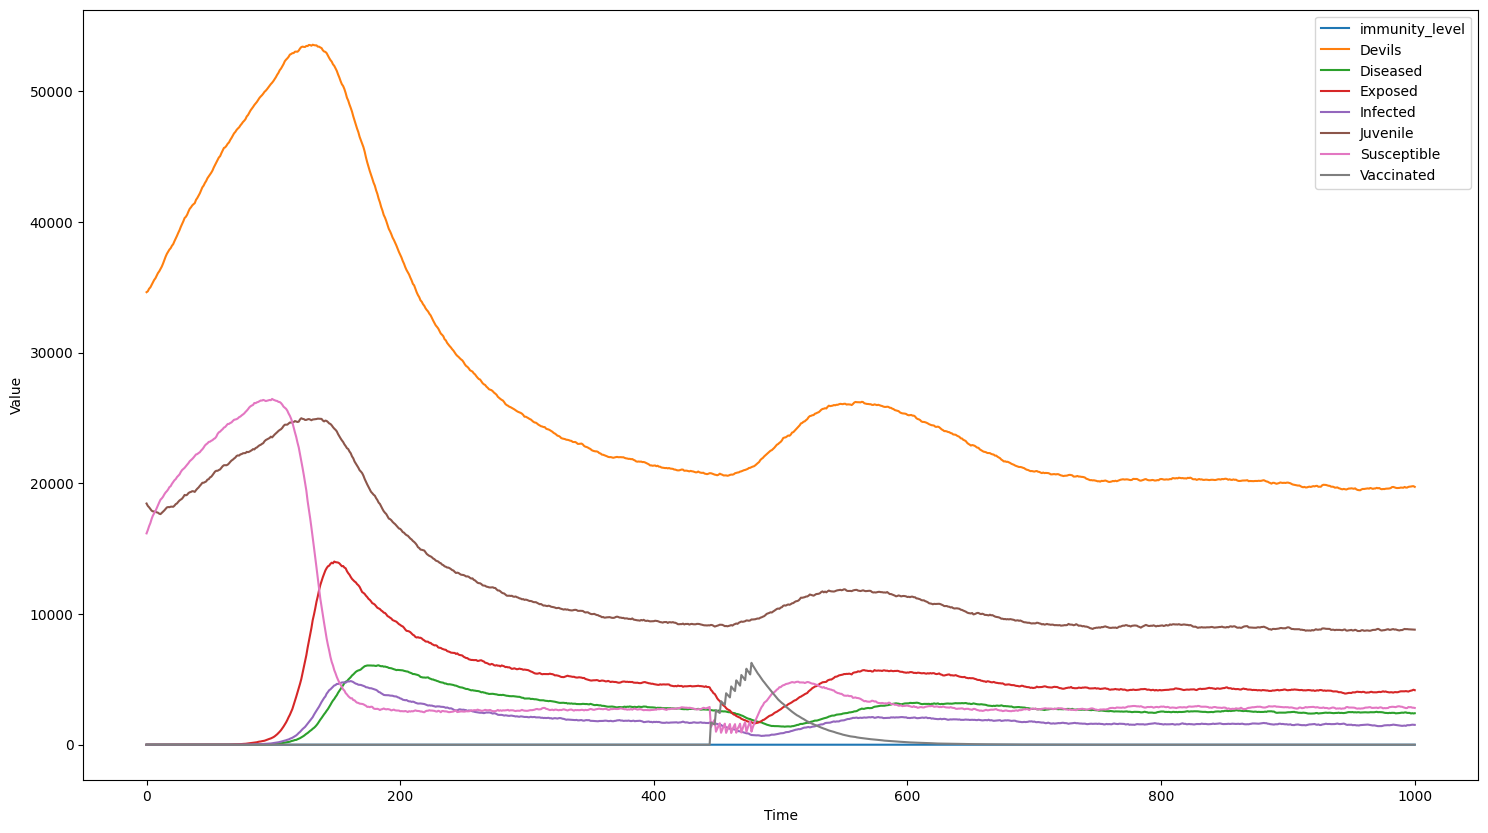

In [40]:
results.plot()

In [9]:
print(variables['cull_rate_diseased'])

0.2


In [10]:
results.plotplotly()

# Visualization

In [11]:
def plot(results, start=0, alpha=0.3):
    carry_cap = int(max(devil_pop)*1.16)
    dftd_start = int(results.model.listOfParameters['DFTD_introduction'].value)
    vaccine_start = 444 + int(variables['vaccine_start'])
    cull_start = 444+ int(variables['vaccine_start'])
    
    program_end = vaccine_start + 12*int(variables['program_length'])
    
    spec_list = [results['Juvenile'], results['Susceptible'], results['Exposed'],
                 results['Infected'], results['Diseased'], results['Vaccinated']]
    total_devils = np.add.reduce(spec_list)
    x = results['time'][start:]
    text_offset = (results['time'].size - start) / 601
    
    plt.figure(figsize=[15, 8])
    plt.title("Tasmanian Devil Population with DFTD: Vaccination+Cull+Natural Immunity", fontsize=18)
    plt.xlabel(f"Time (months) since {dates[start]}", fontsize=14)
    plt.ylabel("Population of Tasmanian Devils", fontsize=14)
    plt.plot(x, total_devils[start:], color='blue', label='Total Devils')
    plt.plot(x, results['Juvenile'][start:], color='purple', alpha=alpha, label='Juvenile')
    plt.plot(x, results['Susceptible'][start:], color='green', alpha=alpha, label='Susceptible')
    plt.plot(x, results['Exposed'][start:], color='magenta', alpha=alpha, label='Exposed')
    plt.plot(x, results['Infected'][start:], color='red', alpha=alpha, label='Infected')
    plt.plot(x, results['Diseased'][start:], color='brown', alpha=alpha, label='Diseased')
    plt.plot(x, results['Vaccinated'][start:], color='cyan', alpha=alpha, label='Vaccinated')
    plt.ylim([-3000, carry_cap])
    if start <= dftd_start:
        plt.plot([dftd_start, dftd_start], [-3000, carry_cap], '--k', alpha=0.3)
        plt.text(dftd_start-10*text_offset, 45000, "DFTD Introduced", rotation="vertical", color="black", fontsize=12)
        plt.text(dftd_start+3*text_offset, 48000, dates[dftd_start], rotation="vertical", color="black", fontsize=12)
    # red vertical line: vax start
    plt.plot([vaccine_start, vaccine_start], [-3000, carry_cap], '--k', alpha=0.3)
    plt.text(vaccine_start-10*text_offset, 39000,
             "Start Program: "+dates[vaccine_start], rotation="vertical", color="black", fontsize=12)
    #plt.text(vaccine_start+3*text_offset, 37000,
    #         dates[vaccine_start], rotation="vertical", color="red", fontsize=12)
    #plt.text(cull_start+3*text_offset, 37000,
    #         dates[cull_start], rotation="vertical", color="red", fontsize=12)
    # red vertical line: end program
    plt.plot([program_end, program_end], [-3000, carry_cap], '--k', alpha=0.3)
    plt.text(program_end-10*text_offset, 39000,
             "End Program: "+dates[program_end], rotation="vertical", color="black", fontsize=12)
    #plt.text(program_end+3*text_offset, 37000,
    #         dates[program_end], rotation="vertical", color="red", fontsize=12)

    #plt.text(program_end+3*text_offset, 37000,
    #         dates[program_end], rotation="vertical", color="red", fontsize=12)
    
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation="vertical", va="center")
    plt.legend(loc='upper right', fontsize=12)

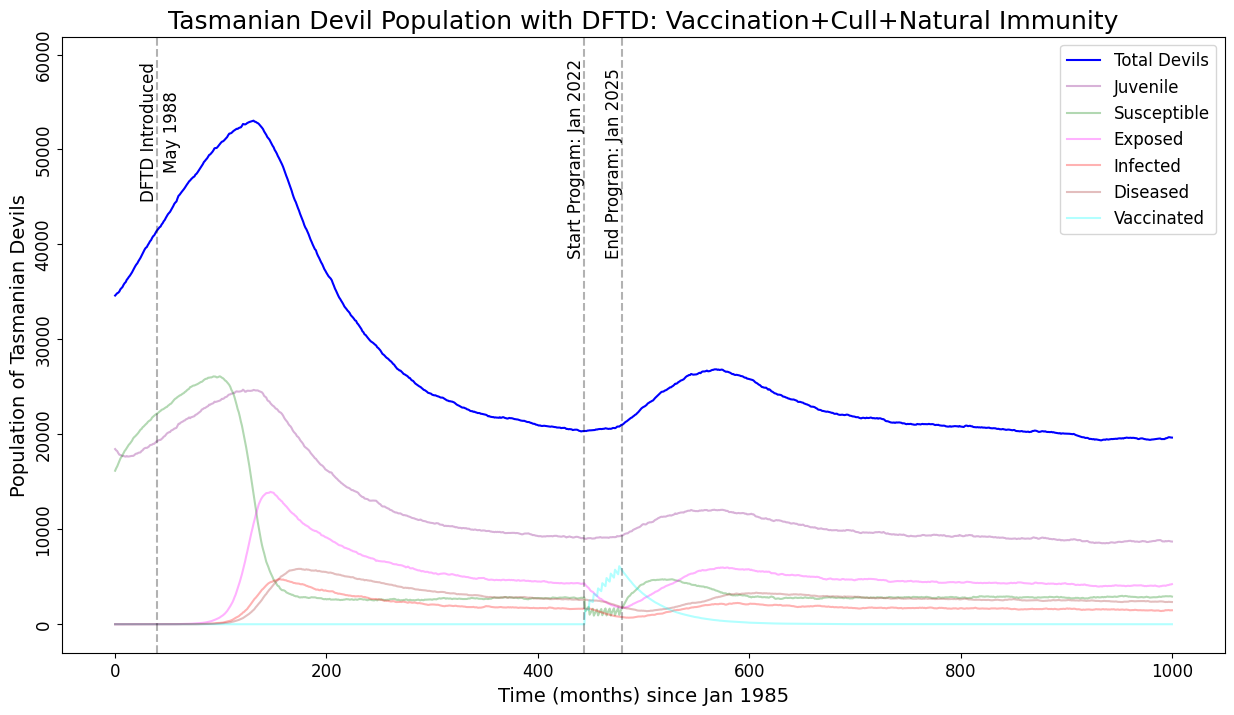

In [12]:
plot(results)

In [13]:
solver = TauHybridCSolver(model, variable=True)

## Configure Solver Widgets

In [29]:
def display_details():
    width = 112
    #width = 70
    d_width = width - 4
    h_width = int(d_width/2)
    pad = " "
    pnt_els = ['='*width]
    
    # Changes to parameters
    pnt_els.append(" ".join(['|', 'Input Parameters:'.ljust(d_width), '|']))
    
    last_half_length=0
    first_half_line = ""
    for n,param_name in enumerate(variables.keys()):
        vt_line = f'{pad}{param_name}: {variables[param_name]} '
        if variables[param_name] != variables_orig[param_name]:
            vt_line += f'{pad}(was {variables_orig[param_name]}) '
        if n%2==1:
            vt_line = first_half_line + " "*(int(width/2)-last_half_length) + vt_line
            half_line = " ".join(['|', vt_line.ljust(d_width), '|'])
            pnt_els.append(half_line)
        else:
            first_half_line = vt_line        
            last_half_length = len(vt_line)
        
    
#     date = dates[444 + int(variables["vaccine_start"])]
#     vt_line = f'{pad}Vaccination Program Start: {variables["vaccine_start"]} ({date})'
#     if variables["vaccine_start"] != variables_orig["vaccine_start"]:
#         prev_date = dates[444 + int(variables_orig["vaccine_start"])]
#         vt_line += f'{pad}(was {variables_orig["vaccine_start"]} ({prev_date}))'
#     pnt_els.append(" ".join(['|', vt_line.ljust(d_width), '|']))
    
#     plvf_line = f'{pad}Program Length (years): {variables["program_length"]}'
#     if variables["program_length"] != variables_orig["program_length"]:
#         plvf_line += f'{pad}(was {variables_orig["program_length"]})'
#     plvf_line = plvf_line.ljust(h_width)
#     plvf_line += f'{pad}Vaccine Frequency (per year): {variables["vaccine_frequency"]}'
#     if variables["vaccine_frequency"] != variables_orig["vaccine_frequency"]:
#         plvf_line += f'{pad}(was {variables_orig["vaccine_frequency"]})'
#     pnt_els.append(" ".join(['|', plvf_line.ljust(d_width), '|']))
    
#     vpvi_line = f'{pad}Vaccination Proportion: {variables["vaccination_proportion"]}'
#     if variables["vaccination_proportion"] != variables_orig["vaccination_proportion"]:
#         vpvi_line += f'{pad}(was {variables_orig["vaccination_proportion"]})'
#     vpvi_line = vpvi_line.ljust(h_width)
#     vpvi_line += f'{pad}Vaccinated Infection Rate: {variables["vaccinated_infection_rate"]}'
#     if variables["vaccinated_infection_rate"] != variables_orig["vaccinated_infection_rate"]:
#         vpvi_line += f'{pad}(was {variables_orig["vaccinated_infection_rate"]})'
#     pnt_els.append(" ".join(['|', vpvi_line.ljust(d_width), '|']))
    pnt_els.append('='*width)
    
    print("\n".join(pnt_els))
    return pnt_els

In [30]:
x = display_details()

| Input Parameters:                                                                                            |
|  vaccinated_infection_rate: 0.25                         vaccination_proportion: 0.6                         |
|  vaccine_frequency: 3                                    vaccine_start: 0                                    |
|  program_length: 3                                       cull_rate_infected: 0.0                             |
|  cull_rate_diseased: 0.2                                 immunity_growth_rate: 0.0                           |
|  immunity_max_level: 0.5                                 immunity_start: 200                                 |


In [31]:
variables

{'vaccinated_infection_rate': 0.25,
 'vaccination_proportion': 0.6,
 'vaccine_frequency': 3,
 'vaccine_start': 0,
 'program_length': 3,
 'cull_rate_infected': 0.0,
 'cull_rate_diseased': 0.2,
 'immunity_growth_rate': 0.0,
 'immunity_max_level': 0.5,
 'immunity_start': 200}

In [32]:
Saved_Results = None
def configure(vaccinated_infection_rate, vaccination_proportion,
              vaccine_frequency, vaccine_start, program_length, 
              cull_rate_infected, cull_rate_diseased, immunity_max_level,
              immunity_growth_rate, immunity_start):
    global Saved_Results
    
    variables['immunity_start'] = immunity_start
    variables['immunity_growth_rate'] = immunity_growth_rate
    variables['immunity_max_level'] = immunity_max_level
    variables['vaccinated_infection_rate'] = vaccinated_infection_rate
    variables['vaccination_proportion'] = vaccination_proportion
    variables['vaccine_frequency'] = vaccine_frequency
    variables['vaccine_start'] = vaccine_start
    variables['program_length'] = program_length
    variables['cull_rate_infected'] = cull_rate_infected
    variables['cull_rate_diseased'] = cull_rate_diseased
    
    model.timespan(np.arange(0, end_sim + 1, 1))
    
    display_details()
    
    variable = {
        "immunity_start" : immunity_start,
        "immunity_growth_rate" : immunity_growth_rate,
        "immunity_max_level" : immunity_max_level,
        "vaccinated_infection_rate": vaccinated_infection_rate,
        "vaccination_proportion": vaccination_proportion,
        "vaccine_frequency": vaccine_frequency,
        "vaccine_start": vaccine_start,
        "program_length": program_length,
        "cull_rate_infected": cull_rate_infected,
        "cull_rate_diseased": cull_rate_diseased,
    }
    results = model.run(with_pr=True, solver=solver, variables=variable)
    Saved_Results = results
    plot(results)

## Create Widgets

In [33]:
s2 = widgets.IntSlider(
    min=0, max=200, step=1, value=variables['vaccine_start'], description="Vaccine Start"
)
s3 = widgets.IntSlider(
    min=0, max=30, step=1, value=variables['program_length'], description="Prog. Len"
)
s4 = widgets.IntSlider(
    min=1, max=12, step=1, value=variables['vaccine_frequency'], description="Vaccine Freq."
)
s5 = widgets.FloatSlider(
    min=0.00, max=1, step=0.01, value=variables['vaccination_proportion'], description="Vacc. Prop."
)
s6 = widgets.FloatSlider(
    min=0.00, max=1, step=0.01, value=variables['vaccinated_infection_rate'], description="Vacc. Inf. R."
)
s8 = widgets.FloatSlider(
    min=0.00, max=1, step=0.01, value=variables['cull_rate_infected'], description="Cull. Inf. R."
)
s9 = widgets.FloatSlider(
    min=0.00, max=1, step=0.01, value=variables['cull_rate_diseased'], description="Cull. Dis. R."
)
s10 = widgets.FloatSlider(
    min=0.0, max=1.0, step=0.01, value=variables['immunity_max_level'], description="Imm. Max"
)
s11 = widgets.FloatSlider(
    min=0.0, max=1.0, step=0.01, value=variables['immunity_growth_rate'], description="Imm. Grow"
)
s12 = widgets.IntSlider(
    min=0, max=1000, step=1, value=variables['immunity_start'], description="Imm. Start"
)

ai_widgets = {'vaccine_start': s2, 'program_length': s3,
              'vaccine_frequency': s4, 'vaccination_proportion': s5,
              'vaccinated_infection_rate': s6, "cull_rate_infected": s8,
              "cull_rate_diseased": s9, 'immunity_max_level': s10,
              "immunity_growth_rate": s11, "immunity_start": s12
             }

In [34]:
def get_layout(vertical=False):
    kwargs = {
        "margin": '0px 10px 10px 0px',
        "padding": '5px 5px 5px 5px'
    }
    if not vertical:
        kwargs['border'] = 'solid 1px red'
    return widgets.Layout(**kwargs)

hb1 = widgets.HBox([s9, s2, s3], layout=get_layout())
hb2 = widgets.HBox([s4, s5, s6], layout=get_layout())
hb3 = widgets.HBox([s10, s11,s12 ], layout=get_layout())

ui = widgets.VBox([hb1, hb2, hb3])

## Run widgets and attempt to calibrate model

In [35]:
out = interactive_output(configure, ai_widgets)
display(out, ui)

Output()

0.0


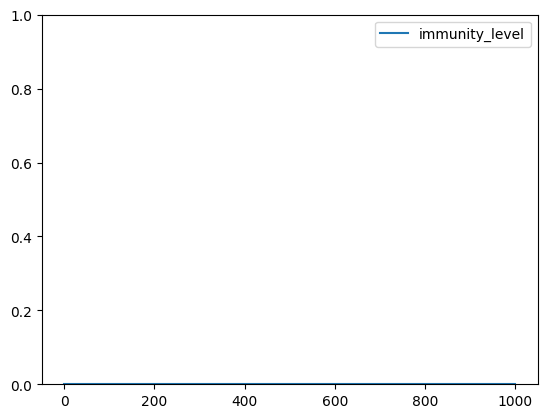

In [36]:
if Saved_Results is not None:
    plt.plot(Saved_Results[0]['immunity_level'], label="immunity_level")
    plt.ylim(0,1)
    plt.legend()
    print(Saved_Results[0]['immunity_level'][-1])

In [22]:
Saved_Results.plotplotly()


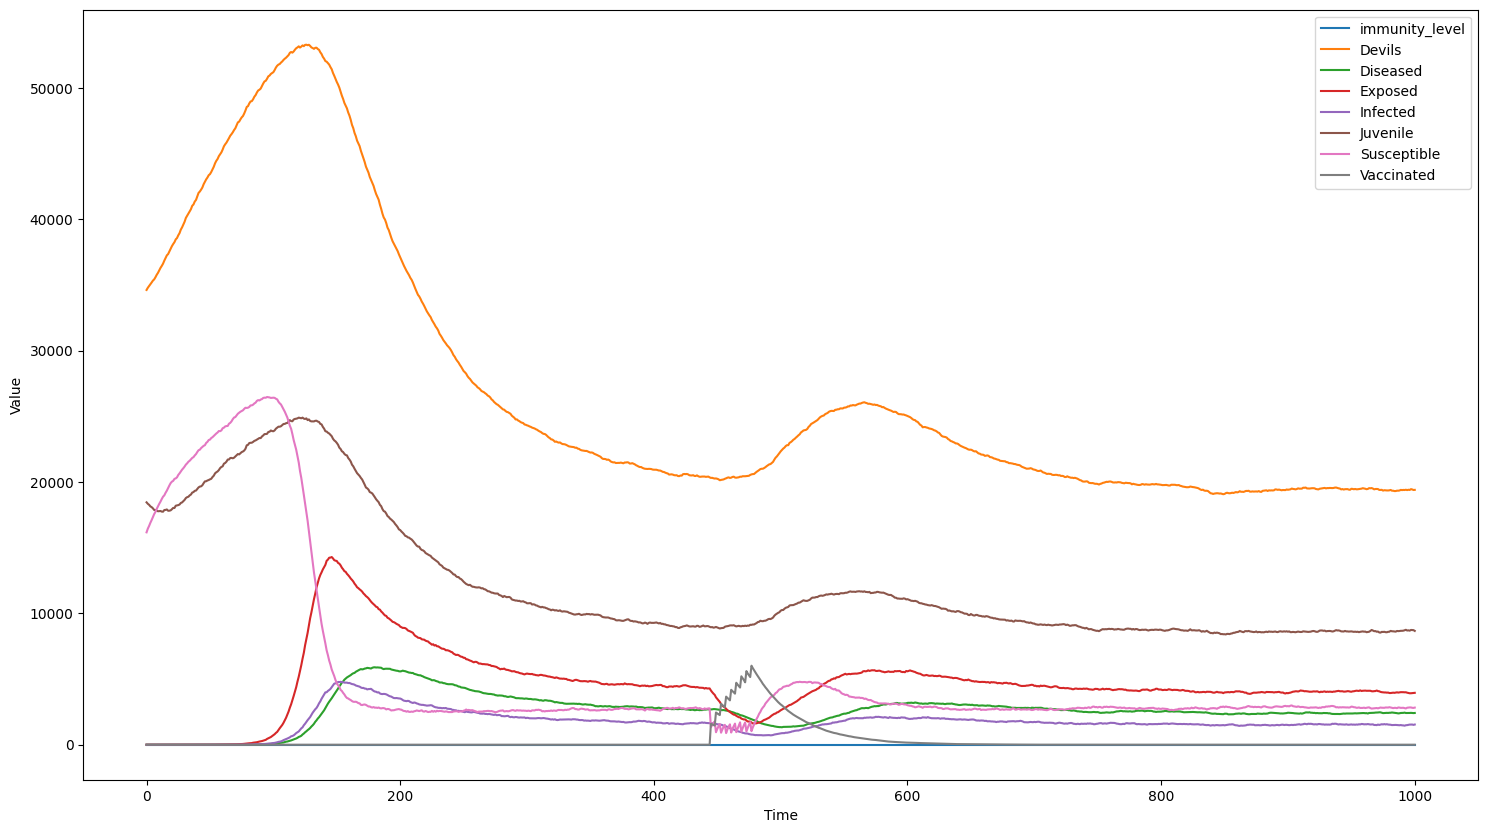

In [23]:
Saved_Results.plot()

In [24]:
Dftd = Saved_Results[0]['Infected'] + Saved_Results[0]['Exposed']+ Saved_Results[0]['Diseased']

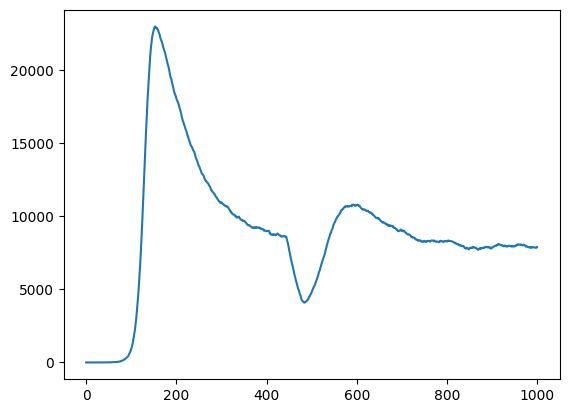

In [25]:
plt.plot(Dftd)

In [26]:
def compute_dftd_extinction_prob(verbose=True, vs=None):
    if vs is None:
        vs = variables.copy()
    if verbose: print(vs)
    ext_count = 0
    for _ in range(100):
        if verbose:  print(".", end='')
        res = model.run(with_pr=True, solver=solver, variables=vs)
        Dftd = res[0]['Infected'] + res[0]['Exposed']+ res[0]['Diseased']
        if min(Dftd[150:]) == 0.0:
            ext_count+=1
    if verbose: print(f" Dftd eradication {ext_count}%")
    return ext_count


In [27]:
def param_sweep___compute_dftd_extinction_prob(param_name, list_of_param_values):
    vs = variables.copy()
    ext_rate = []
    for ndx,pv in enumerate(list_of_param_values):
        vs[param_name] = pv
        ext_rate.append(compute_dftd_extinction_prob(True,vs))
    return ext_rate

In [28]:
raise Exception('stop... no run-all past here')

Exception: stop... no run-all past here

In [ ]:
variables['cull_rate_diseased'] = 0.5

In [ ]:
variables

In [ ]:
%time print(f"Dftd eradication {compute_dftd_extinction_prob()}%")

In [ ]:
%time print(f"Dftd eradication {compute_dftd_extinction_prob()}%")

In [ ]:
pl_values = [5,10,15,20,25,30]
#print(variables)
pl_ext_rate = param_sweep___compute_dftd_extinction_prob('program_length', pl_values)

plt.plot(pl_values,pl_ext_rate)
plt.title('Dftd eradication vs. Program length')
plt.ylim(ymin=0,ymax=100)
plt.xlabel("Program length (years)")
_ = plt.ylabel("DFTD eradication probability")

In [ ]:
print(pl_ext_rate)

In [ ]:
vaccination_proportion_orig = variables['vaccination_proportion']
vp_values = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]
ext_rate = []
for ndx,vp in enumerate(vp_values):
    variables['vaccination_proportion'] = vp
    ext_rate.append(compute_dftd_extinction_prob(False))
variables['vaccination_proportion'] = vaccination_proportion_orig


In [ ]:
plt.plot(vp_values,ext_rate,'.-')
plt.title('Dftd eradication vs. vaccination_proportion')
plt.ylim(ymin=0,ymax=100)
plt.ylabel("probability of permanent disease eradication")
plt.xlabel("Fraction of Devil population vaccinated each session")

In [ ]:
ext_rate

In [ ]:
cull_rate_diseased_orig = variables['cull_rate_diseased']
cr_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
ext_rate2 = []
for ndx,cr in enumerate(cr_values):
    variables['cull_rate_diseased'] = cr
    ext_rate2.append(compute_dftd_extinction_prob(False))
variables['cull_rate_diseased'] = cull_rate_diseased_orig


In [ ]:
plt.plot(cr_values,ext_rate2,'.-')
plt.title('Dftd eradication vs. cull_rate_diseased')
plt.ylim(ymin=0,ymax=100)
plt.ylabel("probability of permanent disease eradication")
plt.xlabel("Fraction of heavily diseased Devils who are culled each month")

In [ ]:
ext_rate2